In [153]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import networkx as nx
from helpers import eig
from sklearn.cluster import KMeans

# Exercise 4

(1000, 1)
(784, 1000)


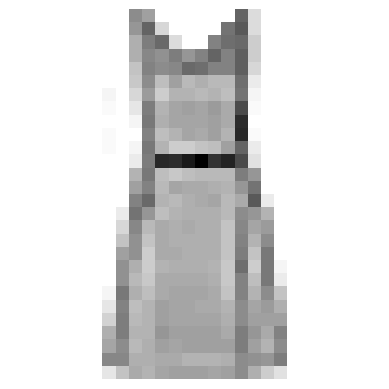

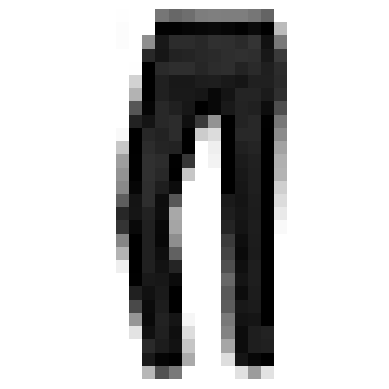

In [154]:
mat = scipy.io.loadmat('hw2_zalando_new.mat')

correct = mat['correct']
items = mat['items']

print(correct.shape)
print(items.shape)


def zalando_plot(z):
    n = 28  # Image size
    A = np.reshape(z, (n, n))

    # Normalize it
    I = np.argmax(np.abs(z))
    za = z[I]
    A = A / za

    B = 1 - A # It looks nicer with a white background.

    # Plot
    plt.imshow(B, cmap='gray', origin='upper')
    plt.axis('off')
    plt.show()

zalando_plot(items[:,0])
zalando_plot(items[:,1])


Clearly pants and dresses are the two items in the dataset

In [155]:
def build_distance(items, w):  #Vectorized way of computing distance
    w = np.array([w]).T
    items = w * items
    S = np.sum(items**2, axis=0, keepdims=True)
    S = np.sqrt(np.maximum(0,(S + S.T - 2 * items.T.dot(items))))   #maximum just to silence the warning message of possible negative values inside (np.sqrt)
    np.fill_diagonal(S, 0)
    return S

# Here is a slower but more intuitive way of computing the distances:
"""
def build_distance(items, w):
    num_points = items.shape[1]
    S = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(i, num_points):
            dist = np.linalg.norm(w * (items[:, i] - items[:, j]))
            S[i, j] = dist
            S[j, i] = dist
    return S
""" 

w = np.ones(items[:,1].shape[0])
S= build_distance(items, w)

### B)

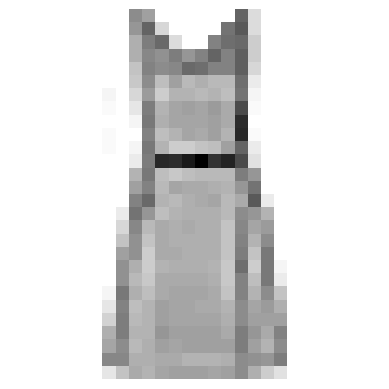

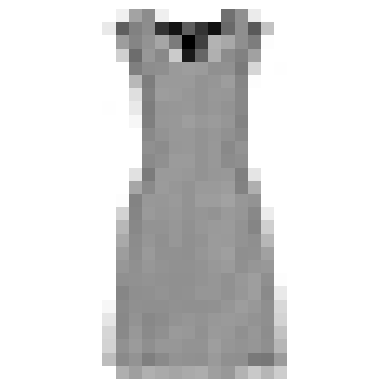

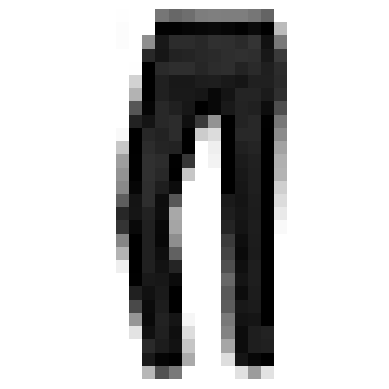

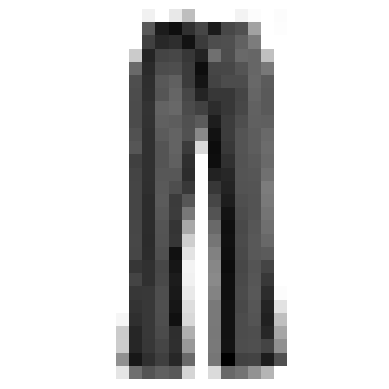

In [156]:
# First item:
zalando_plot(items[:,0])

# Closest to first item:
index = np.argmin(S[0,1:]) + 1
zalando_plot(items[:,index])

# Second item:
zalando_plot(items[:,1])

# Closest to second item
index = np.argmin(S[1,2:]) + 1
zalando_plot(items[:,index])

In [157]:
def build_weights(S):  # Quicker vectorized version
    alpha = 0.5
    W = np.zeros(S.shape)
    sigma = np.std(S, axis = 1)
    W = np.exp(-alpha*S**2/sigma**2)
    W -= np.diag(np.diag(W))
    W = (W+W.T)/2
    return W

def build_weights_slow(S): # Slow but intuitive version
    W = np.zeros(S.shape)
    alpha = 0.5
    for i in range(S.shape[0]):
        sigma = np.std(S[:,i])
        for j in range(S.shape[0]):
            W[i,j] = np.exp((-alpha*S[i,j]**2)/(sigma**2))
    W -= np.diag(np.diag(W))
    W = (W+W.T)/2
    return W

import time

start_time = time.time()
W = build_weights_slow(S)
end_time = time.time()

print(W)
print("Elapsed time slow version: {:.2f} seconds".format(end_time - start_time))

[[0.00000000e+00 2.68312481e-07 1.36933751e-07 ... 6.08580244e-04
  3.25116019e-07 1.76428491e-07]
 [2.68312481e-07 0.00000000e+00 5.93980936e-03 ... 1.80088118e-05
  2.13960027e-05 2.56437328e-01]
 [1.36933751e-07 5.93980936e-03 0.00000000e+00 ... 1.75153947e-05
  2.34822478e-04 3.94580792e-03]
 ...
 [6.08580244e-04 1.80088118e-05 1.75153947e-05 ... 0.00000000e+00
  3.83932734e-06 1.15323883e-05]
 [3.25116019e-07 2.13960027e-05 2.34822478e-04 ... 3.83932734e-06
  0.00000000e+00 1.60736469e-05]
 [1.76428491e-07 2.56437328e-01 3.94580792e-03 ... 1.15323883e-05
  1.60736469e-05 0.00000000e+00]]
Elapsed time slow version: 1.69 seconds


In [158]:
start_time = time.time()
W = build_weights(S)
end_time = time.time()

print(W)
print("Elapsed time fast version: {:.2f} seconds".format(end_time - start_time))

[[0.00000000e+00 2.68312481e-07 1.36933751e-07 ... 6.08580244e-04
  3.25116019e-07 1.76428491e-07]
 [2.68312481e-07 0.00000000e+00 5.93980936e-03 ... 1.80088118e-05
  2.13960027e-05 2.56437328e-01]
 [1.36933751e-07 5.93980936e-03 0.00000000e+00 ... 1.75153947e-05
  2.34822478e-04 3.94580792e-03]
 ...
 [6.08580244e-04 1.80088118e-05 1.75153947e-05 ... 0.00000000e+00
  3.83932734e-06 1.15323883e-05]
 [3.25116019e-07 2.13960027e-05 2.34822478e-04 ... 3.83932734e-06
  0.00000000e+00 1.60736469e-05]
 [1.76428491e-07 2.56437328e-01 3.94580792e-03 ... 1.15323883e-05
  1.60736469e-05 0.00000000e+00]]
Elapsed time fast version: 0.04 seconds


### C)

(0.0, 0.002)

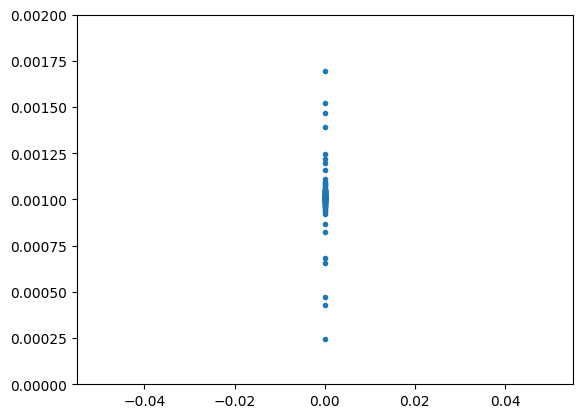

In [159]:
D = np.diag(np.sum(W, axis = 1))
L = D - W 

eigvals, eigvectors = eig(L)

xvals = np.zeros((eigvectors.shape[0],1))
plt.plot(xvals,eigvectors[:,1], '.')
plt.ylim(bottom = 0, top = 0.002)


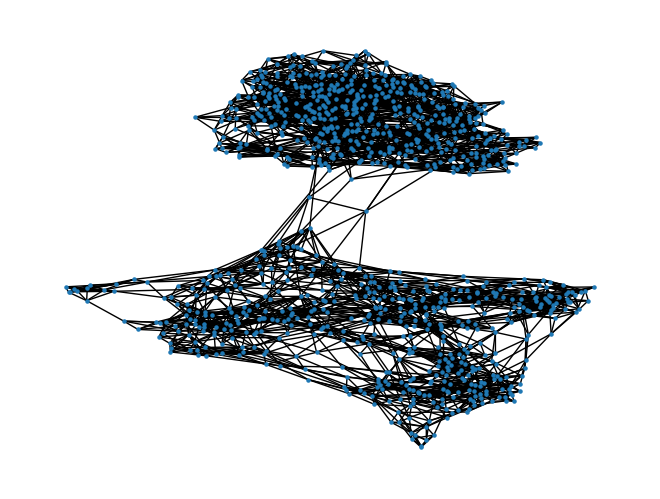

In [160]:

def knn(Dist, k):
    n = Dist.shape[0]
    W = np.zeros((n, n))
    knn_indices = np.argsort(Dist, axis=1)[:, :k+1]
    
    for i in range(n):
        W[i, knn_indices[i, 1:]] = 1
        W[knn_indices[i, 1:], i] = 1
    return W 

W = knn(S, 5)
G = nx.from_numpy_matrix(W)
nx.draw(G, node_size = 5)

In [161]:
def cluster(W, k):
    D = np.diag(np.sum(W, axis = 1))
    L = D - W
    _, eigvectors = eig(L)
    U = eigvectors[:,:k]
    kmeans = KMeans(n_clusters = k).fit(U)
    return kmeans.labels_

clusters = cluster(W, 2)



In [162]:
correct_adj = (correct - 1).T[0] # To make it in the same format as clusters

print(np.mean(clusters == correct_adj))

0.998
